# Photodiode and TIA noise analysis

Plots for photodiode and TIA noise sources and signal-to-noise ratios

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 1

from pathlib import Path

import numpy as np
import scipy.stats
import scipy.fft
import scipy.interpolate

import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

%aimport w7x_bes_tools.detectors

rng = np.random.default_rng()
savefig = True


In [2]:
from w7x_bes_tools import detectors

diodes = {
    'API_C164_PIN' : detectors.PinDiode(
        name='AP PDB-C164 disc. PIN',
        responsivity=0.43,  # A/W @ 650 nm
        darkcurrent_ref=1e-9,  # typ 1 nA, max 10 nA @ T=20C
        junction_cap_ref=7e-12,  # typ 7 pF @ Vr=10V
        vb_ref=10,  # reference bias voltage for junction cap.
        r_shunt=500e6,  # shunt resistance
    ),
    'Hama_S13620_PIN' : detectors.PinDiode(
        name='Hama. S13620 8x8 PIN',
        responsivity=0.49,  # A/W @ 650 nm
        darkcurrent_ref=0.3e-9,  # typ 10 pA, max 300 pA @ Vr=10mV, T=20C
        junction_cap_ref=15e-12,  # typ 15 pF @ Vr=8.6V
        vb_ref=8.6,
    ),
    'AP_SD197_APD' : detectors.ApdDiode(
        name='AP SD197 disc. APD',
        qe=0.76,  # QE @ 650 nm
        gain=300,  # gain @ Vr=330 V
        darkcurrent_ref=6e-9,  # typ 1 nA, max 10 nA @ Vr=330V, M=50
        junction_cap_ref=25e-12,  # typ 9 pF @ Vr=330V, M=50
        # noise_current=0.8e-12,
        noise_factor=2.2,
        vb_ref=1800,  # reference bias for gain and junction cap.
    ),
    'Hama_S8550_APD' : detectors.ApdDiode(
        name='Hama. S8550 4x8 APD',
        qe=0.85,  # QE @ 650 nm
        gain=50,  # gain @ Vr=330 V
        darkcurrent_ref=1e-9,  # typ 1 nA, max 10 nA @ Vr=330V, M=50
        junction_cap_ref=9e-12,  # typ 9 pF @ Vr=330V, M=50
        noise_index=0.2,
        vb_ref=330,  # reference bias for gain and junction cap.
    ),
}

AP PDB-C164 disc. PIN
  QE = 81.3 %
  Resp. = 0.43 A/W
  Dark current (total or vol.) = 1.0 nA
  Junction cap = 7.0 pF
  Shunt res. = 500 MOhms
  Ref. bias voltage = 10 V
  Ref. temp. = 20 C
Hama. S13620 8x8 PIN
  QE = 92.6 %
  Resp. = 0.49 A/W
  Dark current (total or vol.) = 0.3 nA
  Junction cap = 15.0 pF
  Shunt res. = 250 MOhms
  Ref. bias voltage = 9 V
  Ref. temp. = 20 C
AP SD197 disc. APD
  QE = 76.0 %
  Resp. = 0.40 A/W
  Dark current (total or vol.) = 6.0 nA
  Junction cap = 25.0 pF
  Shunt res. = 250 MOhms
  Ref. bias voltage = 1800 V
  Ref. temp. = 20 C
  Gain = 300
  Noise factor = 2.2
Hama. S8550 4x8 APD
  QE = 85.0 %
  Resp. = 0.45 A/W
  Dark current (total or vol.) = 1.0 nA
  Junction cap = 9.0 pF
  Shunt res. = 250 MOhms
  Ref. bias voltage = 330 V
  Ref. temp. = 20 C
  Gain = 50
  Noise index = 0.20
  Noise factor = 2.2


# Diodes and noise

Photodiodes convert incident radiant flux $P_{inc}$ into a photocurrent $I_{ph}$:

$$I_{ph} = G\cdot R\cdot P_{inc}\quad[A]$$

where $G$ is diode gain, $R$ is diode responsivity in $A/W$ and $P_{inc}$ is the indicdent radiant flux in $W$.  The diode responsivity $R$ is related to the diode quantum efficiency $QE$:

$$R = QE\cdot\frac{\lambda[nm]}{1240}\quad[A/W]$$

PIN diodes have gain $G=1$, and APDs have $G>1$ (typ. 50-100).

Photodiodes are susceptible to shot noise and thermal noise, and APDs additionally are susceptible to "excess noise".  The excess noise is characterized by the excess noise factor $F\ge 1$.  APDs have $F>1$, and to unify notation, PIN diodes conceptualy have $F=1$.  PIN diode and APD noise sources:
- Shot noise from photocurrent and dark (leakage) current
  - APDs have volume dark current that is subject to gain and excess noise and surface dark current that is not subject to gain and excess noise
  - Shot noise from the photocurrent is the irreducible minimum noise, and it is often known as the "photon noise limit"
- Thermal (Johnson) noise from diode shunt resistance
  - Negligible for APDs; likely negligible for PIN diodes
- APD only: Excess noise factor
  - A multiplicitive factor on shot noise terms

All of the above noise sources are white noise with a flat frequency spectrum.  (As discussed below, the diode junction capacitance contributes to the "ENC" or channel noise in the JFET and TIA.)  Noise sources are expressed in terms of current noise power density (CNPD), denoted by $i^2$ with units $A^2/Hz$.  When expressed as a power density, noise sources are additive:

$$i^2_{total} = i^2_1 + i^2_2 + i^2_3\cdots$$

Noise current $i^2$ may be frequency independent (flat, white noise) or frequency dependent.  Shot noise and thermal noise are flat, but "ENC" noise discussed below is frequency dependent.  For flat noise sources, the RMS noise current is

$$I_{noise,rms}=\sqrt{i^2_{total} * B}\quad[A]$$

where $B$ is the bandwidth in $Hz$.  More generally, for frequency dependent noise sources, the RMS noise current is

$$I_{noise,rms}=\sqrt{\int i^2_{total}(\omega)\,d\omega}\quad[A]$$

The *instantaineous* signal-to-noise ratio $SNR$ is

$$SNR = \frac{I_{ph}}{I_{noise,rms}}$$

The frequency-resolved noise floor is lower than indicated by the instantaineous $SNR$ due to time averaged statistics.

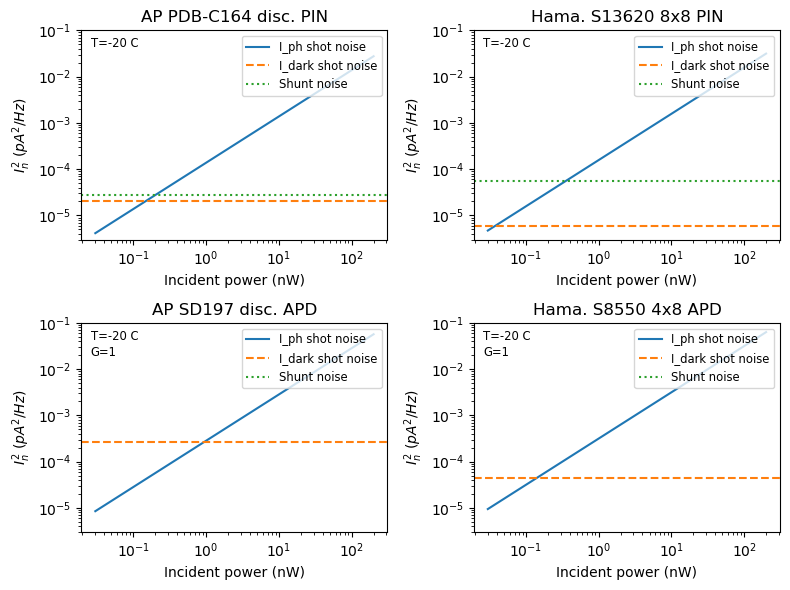

In [3]:
ncols, nrows = 2, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

p_inc = np.geomspace(0.03,200) * 1e-9  # incident power [W]
temp = -20  # temp [C]

iplot=0
for diode in diodes.values():
    plt.sca(axes.flat[iplot])
    plt.title(diode.name)
    plt.loglog(
        p_inc*1e9,  # convert to nW
        diode.photocurrent_shot_noise_CNPD(p_inc) / diode.gain**2 * 1e24,  # convert to pA^2/Hz
        label='I_ph shot noise', 
        c='C0')
    plt.axhline(
        diode.dark_current_shot_noise_CNPD(t=temp) / diode.gain**2 * 1e24,
        label='I_dark shot noise', 
        ls='--', 
        c='C1')
    plt.axhline(
        diode.shunt_noise_CNPD(t=temp) / diode.gain**2 * 1e24,
        label='Shunt noise', 
        ls=':', 
        c='C2')
    plt.xlabel('Incident power (nW)')
    plt.ylabel('$I_n^2$ ($pA^2/Hz$)')
    plt.ylim(3e-6,1e-1)
    plt.legend(fontsize='small', loc='upper right')
    plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
    if isinstance(diode, detectors.ApdDiode):
        plt.annotate('G=1', (0.03,0.84), xycoords='axes fraction', fontsize='small')
    iplot += 1

plt.tight_layout()

if savefig:
    plt.savefig(f'plots/diode_noise_sources.pdf')

# Diode comparison (no TIA)

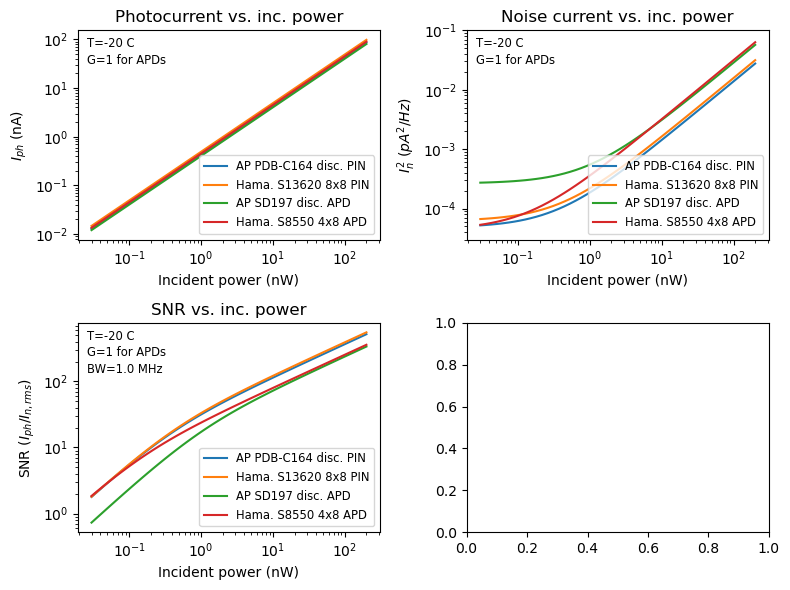

In [4]:
ncols, nrows = 2, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

p_inc = np.geomspace(0.03,200) * 1e-9  # incident power [W]
temp = -20  # temp [C]
bw=1e6  # bandwidth [Hz]

iplot = 0

# photocurrent vs. inc. power
plt.sca(axes.flat[iplot])
plt.title('Photocurrent vs. inc. power')
for diode in diodes.values():
    plt.loglog(
        p_inc*1e9,
        diode.photocurrent(p_inc)/diode.gain * 1e9,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('$I_{ph}$ (nA)')
plt.legend(fontsize='small', loc='lower right')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate('G=1 for APDs', (0.03,0.84), xycoords='axes fraction', fontsize='small')
iplot +=1

# noise vs. inc. power
plt.sca(axes.flat[iplot])
plt.title('Noise current vs. inc. power')
for diode in diodes.values():
    noise_CNPD = diode.photocurrent_shot_noise_CNPD(p_inc) + \
        diode.dark_current_shot_noise_CNPD(t=temp) + \
        diode.shunt_noise_CNPD(t=temp)
    plt.loglog(
        p_inc*1e9,
        noise_CNPD / diode.gain**2 * 1e24,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('$I_n^2$ ($pA^2/Hz$)')
plt.ylim(3e-5,1e-1)
plt.legend(fontsize='small', loc='lower right')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate('G=1 for APDs', (0.03,0.84), xycoords='axes fraction', fontsize='small')
iplot+=1

# SNR vs. inc. power
plt.sca(axes.flat[iplot])
plt.title(f'SNR vs. inc. power')
for diode in diodes.values():
    photocurrent = diode.photocurrent(p_inc)
    noise_current = np.sqrt(bw*(diode.photocurrent_shot_noise_CNPD(p_inc) + \
        diode.dark_current_shot_noise_CNPD(t=temp) + \
        diode.shunt_noise_CNPD(t=temp)))
    plt.loglog(
        p_inc*1e9,
        photocurrent/noise_current,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('SNR ($I_{ph}/I_{n,rms}$)')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate('G=1 for APDs', (0.03,0.84), xycoords='axes fraction', fontsize='small')
plt.annotate(f'BW={bw/1e6:.1f} MHz', (0.03,0.76), xycoords='axes fraction', fontsize='small')
plt.legend(fontsize='small',
    loc='lower right')
iplot+=1

plt.tight_layout()

if savefig:
    plt.savefig(f'plots/diode_performance.pdf')

# Transimpedance amplifier (TIA)

TIA current noise sources

- Shot noise from FET gate current
- Thermal (Johnson) noise from feedback resistor
- Current noise from TIA voltage noise and input capacitance
  - Input capacitance includes diode junction cap., FET cap., and board stray cap.

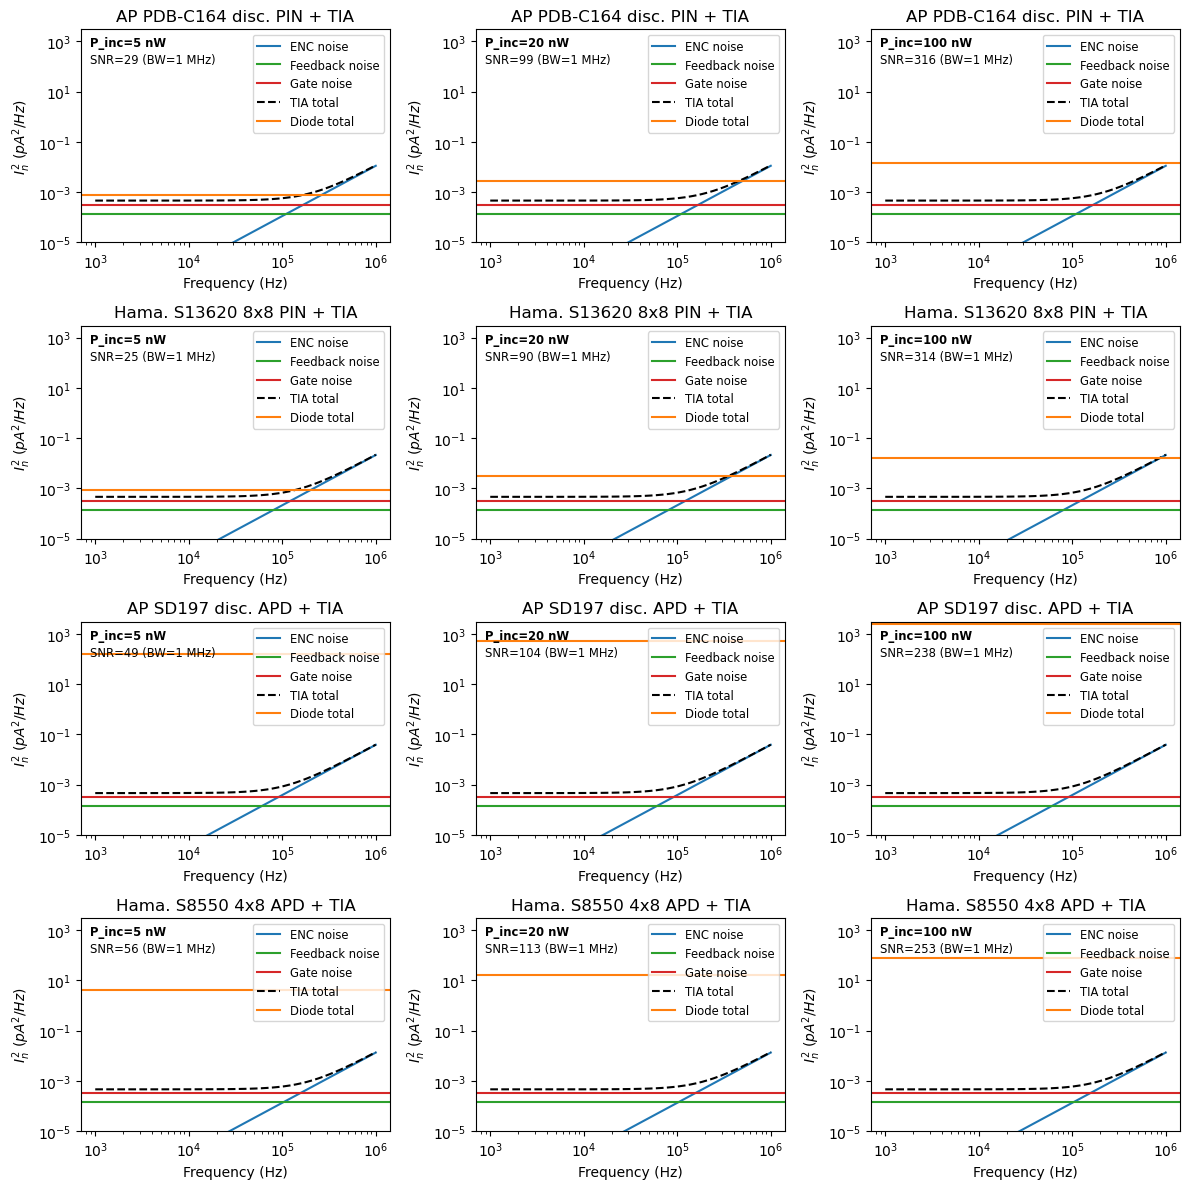

In [3]:
tia = detectors.TIA()

p_inc_values = np.array([5, 20, 100]) * 1e-9  # W
temp = -20  # C
bw = 1e6  # Hz
f_space = np.geomspace(1e3, bw)  # Hz
f_intervals = np.diff(f_space, prepend=0)  # Hz

ncols, nrows = 3, len(diodes)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
iplot=0
for diode in diodes.values():
    for p_inc in p_inc_values:
        plt.sca(axes.flat[iplot])
        plt.title(f'{diode.name} + TIA')
        I_photo = diode.photocurrent(p_inc=p_inc)
        diode_CNPD = (diode.photocurrent_shot_noise_CNPD(p_inc) + \
            diode.dark_current_shot_noise_CNPD(t=temp) + \
            diode.shunt_noise_CNPD(t=temp))  # nA^2/Hz
        feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
        gate_noise_CNPD = tia.gate_noise_CNPD()
        diode_junction_cap = diode.junction_cap()
        enc_noise_CNPD = tia.enc_noise_CNPD(f=f_space, diode_junction_cap=diode_junction_cap)
        TIA_noise_NCPD = enc_noise_CNPD + gate_noise_CNPD + feedback_noise_CNPD
        total_noise = TIA_noise_NCPD + diode_CNPD
        int_noise = np.sqrt(np.sum(total_noise * f_intervals))  # I_n,rms
        SNR = I_photo / int_noise
        plt.loglog(f_space, enc_noise_CNPD*1e24, label='ENC noise', c='C0')
        plt.axhline(feedback_noise_CNPD*1e24, label='Feedback noise', c='C2')
        plt.axhline(gate_noise_CNPD*1e24, label='Gate noise', c='C3')
        plt.loglog(f_space, TIA_noise_NCPD*1e24, label='TIA total', c='k', ls='--')
        plt.axhline(diode_CNPD*1e24, label='Diode total', c='C1')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('$I_n^2$ ($pA^2/Hz$)')
        plt.ylim(1e-5,3e3)
        plt.annotate(f'P_inc={p_inc*1e9:.0f} nW',
            xycoords='axes fraction',
            xy=[0.03,0.92],
            fontsize='small',
            fontweight='bold')
        plt.annotate(f'SNR={SNR:.0f} (BW={bw/1e6:.0f} MHz)',
            xycoords='axes fraction',
            xy=[0.03,0.84],
            fontsize='small')
        plt.legend(loc='upper right', fontsize='small')
        iplot += 1

plt.tight_layout()

if savefig:
    plt.savefig(f'plots/detector_noise_vs_power.pdf')

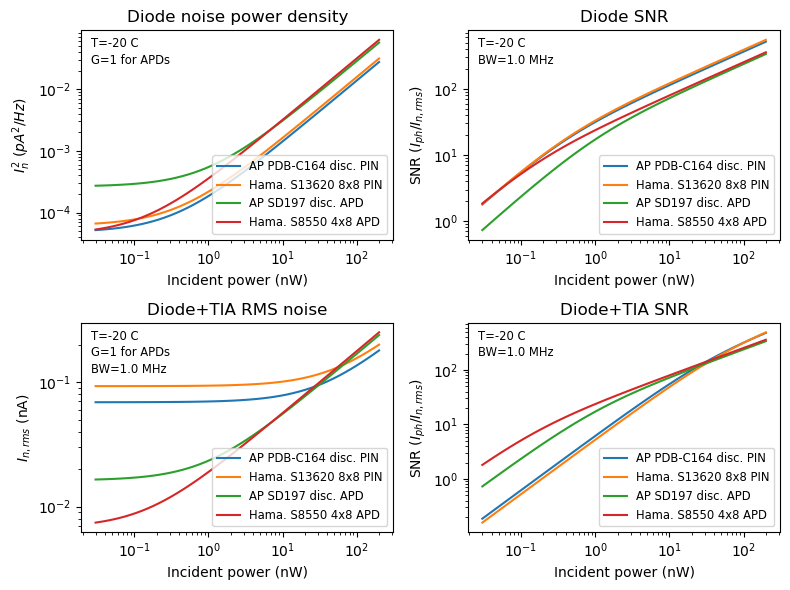

In [6]:
ncols, nrows = 2,2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

p_inc = np.geomspace(0.03,200) * 1e-9 # incident power [W]
temp = -20  # temp C
bw = 1e6  # Hz
f_space = np.geomspace(1e3, bw)  # Hz
f_intervals = np.diff(f_space, prepend=0)  # Hz

iplot = 0

# diode noise vs. inc. power
plt.sca(axes.flat[iplot])
plt.title('Diode noise power density')
for diode in diodes.values():
    noise_CNPD = diode.photocurrent_shot_noise_CNPD(p_inc) + \
        diode.dark_current_shot_noise_CNPD(t=temp) + \
        diode.shunt_noise_CNPD(t=temp)
    plt.loglog(
        p_inc*1e9,
        noise_CNPD / diode.gain**2 * 1e24,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('$I_n^2$ ($pA^2/Hz$)')
# plt.ylim(3e-15,3e-13)
plt.legend(fontsize='small', loc='lower right')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate('G=1 for APDs', (0.03,0.84), xycoords='axes fraction', fontsize='small')
iplot+=1

# diode SNR vs. inc. power
plt.sca(axes.flat[iplot])
plt.title(f'Diode SNR')
for diode in diodes.values():
    photocurrent = diode.photocurrent(p_inc)
    noise_current = np.sqrt(bw*(diode.photocurrent_shot_noise_CNPD(p_inc) + \
        diode.dark_current_shot_noise_CNPD(t=temp) + \
        diode.shunt_noise_CNPD(t=temp)))
    plt.loglog(
        p_inc*1e9,
        photocurrent/noise_current,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('SNR ($I_{ph}/I_{n,rms}$)')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate(f'BW={bw/1e6:.1f} MHz', (0.03,0.84), xycoords='axes fraction', fontsize='small')
plt.legend(fontsize='small',
    loc='lower right')
iplot+=1

# diode+TIA noise vs. inc. power
plt.sca(axes.flat[iplot])
plt.title('Diode+TIA RMS noise')
for diode in diodes.values():
    diode_CNPD = diode.photocurrent_shot_noise_CNPD(p_inc) + \
        diode.dark_current_shot_noise_CNPD(t=temp) + \
        diode.shunt_noise_CNPD(t=temp)
    feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
    gate_noise_CNPD = tia.gate_noise_CNPD()
    diode_junction_cap = diode.junction_cap()
    enc_noise_CNPD = tia.enc_noise_CNPD(f=f_space, diode_junction_cap=diode_junction_cap)
    enc_noise_total = np.sum(enc_noise_CNPD * f_intervals)/bw
    TIA_noise_CNPD = enc_noise_total + gate_noise_CNPD + feedback_noise_CNPD
    rms_noise = np.sqrt((diode_CNPD + TIA_noise_CNPD) / diode.gain**2 * bw)
    plt.loglog(
        p_inc*1e9,
        rms_noise*1e9,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('$I_{n,rms}$ (nA)')
# plt.ylim(3e-12,3e-10)
plt.legend(fontsize='small', loc='lower right')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate('G=1 for APDs', (0.03,0.84), xycoords='axes fraction', fontsize='small')
plt.annotate(f'BW={bw/1e6:.1f} MHz', (0.03,0.76), xycoords='axes fraction', fontsize='small')
iplot+=1

# diode+TIA SNR vs. inc. power
plt.sca(axes.flat[iplot])
plt.title('Diode+TIA SNR')
for diode in diodes.values():
    photocurrent = diode.photocurrent(p_inc) / diode.gain
    diode_CNPD = diode.photocurrent_shot_noise_CNPD(p_inc) + \
        diode.dark_current_shot_noise_CNPD(t=temp) + \
        diode.shunt_noise_CNPD(t=temp)
    feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
    gate_noise_CNPD = tia.gate_noise_CNPD()
    diode_junction_cap = diode.junction_cap()
    enc_noise_CNPD = tia.enc_noise_CNPD(f=f_space, diode_junction_cap=diode_junction_cap)
    enc_noise_total = np.sum(enc_noise_CNPD * f_intervals)/bw
    TIA_noise_CNPD = enc_noise_total + gate_noise_CNPD + feedback_noise_CNPD
    rms_noise = np.sqrt((diode_CNPD + TIA_noise_CNPD) / diode.gain**2 * bw)
    SNR = photocurrent / rms_noise
    plt.loglog(
        p_inc*1e9,
        SNR,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('SNR ($I_{ph}/I_{n,rms}$)')
plt.annotate(f'T={temp:.0f} C', (0.03,0.92), xycoords='axes fraction', fontsize='small')
plt.annotate(f'BW={bw/1e6:.1f} MHz', (0.03,0.84), xycoords='axes fraction', fontsize='small')
plt.legend(fontsize='small', loc='lower right')
iplot+=1

plt.tight_layout()

if savefig:
    plt.savefig(f'plots/detector_and_diode_noise.pdf')

# Diode+TIA SNR vs. incident power and bandwidth

FileNotFoundError: [Errno 2] No such file or directory: 'plots/detector_noise_contours.pdf'

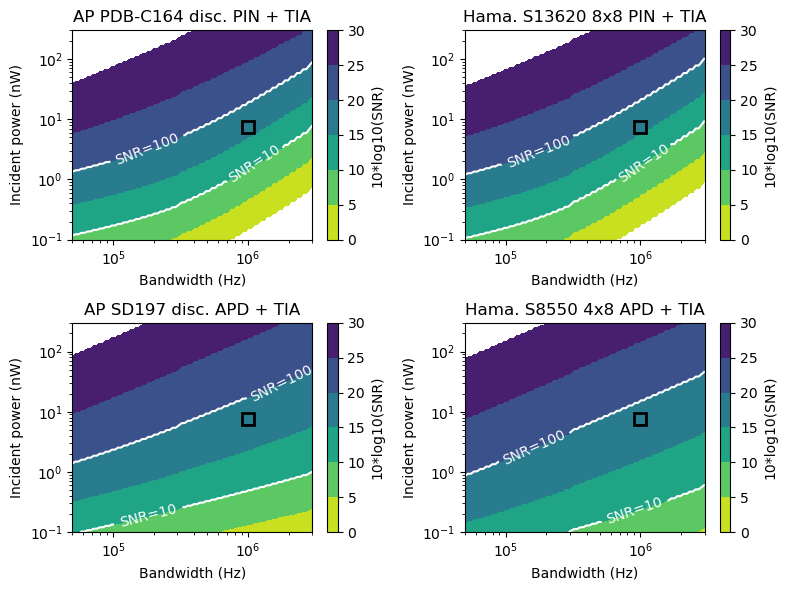

In [10]:
ncols, nrows = 2,2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))

np_inc, nbw = 80, 80

p_inc_array = np.geomspace(1e-1,3e2,np_inc) * 1e-9  # W
f_max=3e6  # Hz
f_space = np.geomspace(1e3,f_max,80)  # Hz
f_intervals = np.diff(f_space, prepend=0)  # Hz
bw_ref_array = np.geomspace(50e3,f_max,nbw)  # Hz

iplot=0
for diode in diodes.values():
    plt.sca(axes.flat[iplot])
    plt.title(f'{diode.name} + TIA')
    SNR = np.zeros((np_inc, nbw))
    for ip, p_inc in enumerate(p_inc_array):
        I_photo = diode.photocurrent(p_inc=p_inc)
        diode_CNPD = (diode.photocurrent_shot_noise_CNPD(p_inc) + \
            diode.dark_current_shot_noise_CNPD(t=temp) + \
            diode.shunt_noise_CNPD(t=temp))  # nA^2/Hz
        feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
        gate_noise_CNPD = tia.gate_noise_CNPD()
        diode_junction_cap = diode.junction_cap()
        enc_noise_CNPD = tia.enc_noise_CNPD(f=f_space, diode_junction_cap=diode_junction_cap)
        TIA_noise_NCPD = enc_noise_CNPD + gate_noise_CNPD + feedback_noise_CNPD
        total_noise = TIA_noise_NCPD + diode_CNPD
        noise_times_bw = total_noise * f_intervals
        for ibw, bw_ref in enumerate(bw_ref_array):
            int_noise = np.sqrt(np.sum(noise_times_bw[f_space<=bw_ref]))  # I_n,rms
            SNR[ip, ibw] = I_photo / int_noise
    plt.contourf(
        bw_ref_array, 
        p_inc_array*1e9, 
        10*np.log10(SNR),
        levels=np.linspace(0,30,7),
        cmap='viridis_r'
        )
    plt.xscale('log')
    plt.xlabel('Bandwidth (Hz)')
    plt.yscale('log')
    plt.ylabel('Incident power (nW)')
    plt.clim(0,30)
    cb = plt.colorbar()
    cb.set_label('10*log10(SNR)')
    clines = plt.contour(
        bw_ref_array, 
        p_inc_array*1e9, 
        10*np.log10(SNR),
        levels=[10,20], colors='w')
    plt.clabel(clines, colors='w', fmt={10:'SNR=10', 20:'SNR=100'})
    plt.plot(1e6,7.5, 'sk', ms=8, mew=2, fillstyle='none')
    iplot += 1

plt.tight_layout()

if savefig:
    plt.savefig(f'plots/detector_noise_contours.pdf')

# Simulated signal spectrum with noise and plasma fluctuation

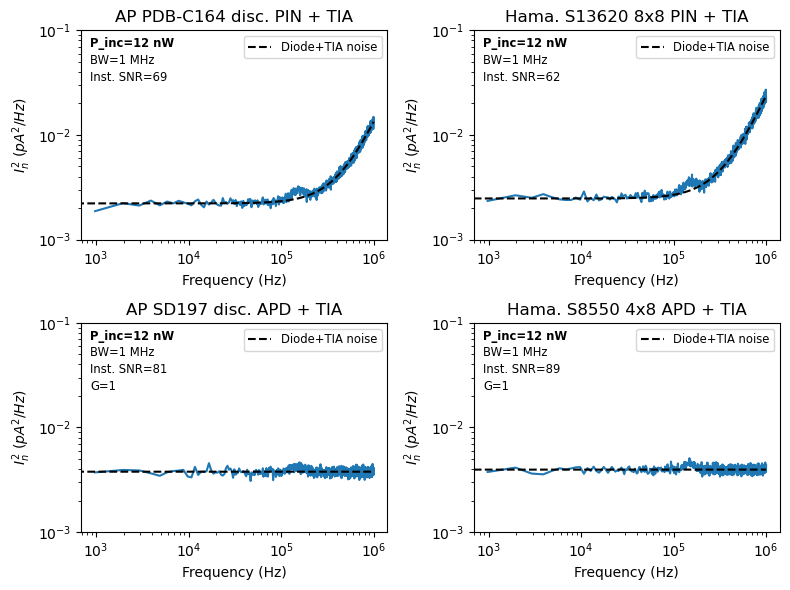

In [4]:
p_inc = 20e-9 * (63/80)**2  # W

temp = -20  # photodiode temperature, C

n_rms = 2e-3  # density RMS fluctuation
p_rms = p_inc * (0.5 * n_rms)  # incident power RMS fluctuation
        # (dI/I)/(dn/n) = 0.5 corresponds to high n ~ 1e20/cm**3
f0 = 150e3  # mode center frequency, Hz
f_fwhm = 50e3  # mode FWHM, Hz
f_sd = f_fwhm / ( 2 * np.sqrt(2*np.log(2)) )  # mode frequency std. dev., Hz

f_sample = 2.e6
bw = f_sample/2

nfft = 2048
nbins = 256*2
nsamples = nfft * nbins

freqs = scipy.fft.rfftfreq(nfft, 1/f_sample)
nfreqs = nfft//2 + 1
assert(freqs.size == nfreqs)
fres = freqs[1]
assert(fres == f_sample / nfft)

freqs_full = scipy.fft.rfftfreq(nsamples, 1/f_sample)

ncols, nrows = 2,2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
iplot=0
for diode in diodes.values():
    plt.sca(axes.flat[iplot])
    plt.title(f'{diode.name} + TIA')

    # diode CNPD (current noise power density)
    diode_CNPD = (diode.photocurrent_shot_noise_CNPD(p_inc) + \
        diode.dark_current_shot_noise_CNPD(t=temp) + \
        diode.shunt_noise_CNPD(t=temp))  # nA^2/Hz

    # TIA CNPD
    feedback_noise_CNPD = tia.feedback_noise_CNPD(t=temp)  # nA^2/Hz
    gate_noise_CNPD = tia.gate_noise_CNPD()
    diode_junction_cap = diode.junction_cap()
    enc_noise_CNPD = tia.enc_noise_CNPD(f=freqs, diode_junction_cap=diode_junction_cap)

    # total noise CNPD
    total_noise_CNPD = (enc_noise_CNPD + gate_noise_CNPD + feedback_noise_CNPD + diode_CNPD) / diode.gain**2

    # RMS noise and SNR
    i_rms = np.sqrt(np.mean(total_noise_CNPD) * bw)  # I_n,rms
    I_photo = diode.photocurrent(p_inc=p_inc) / diode.gain
    SNR = I_photo / i_rms

    # noise fourier components
    enc_noise_CNPD_full = tia.enc_noise_CNPD(f=freqs_full, diode_junction_cap=diode_junction_cap)
    total_noise_CNPD_full = (enc_noise_CNPD_full + gate_noise_CNPD + feedback_noise_CNPD + diode_CNPD) / diode.gain**2
    amplitudes = np.sqrt( total_noise_CNPD_full * bw * nsamples) * rng.standard_normal(freqs_full.size)
    amplitudes[0] = I_photo * nsamples
    phases = 2*np.pi * rng.random(freqs_full.size) 
    phases[0] = 0
    fourier_comp = amplitudes * np.exp(1.j * phases)

    # plasma perturbation fourier components
    I_rms = diode.photocurrent(p_inc=p_rms) / diode.gain
    i2_mean_mode = I_rms**2 / bw
    i2_f_mode_rel = np.exp(-0.5*(freqs_full-f0)**2 / f_sd**2)
    i2_f_mode = i2_mean_mode * i2_f_mode_rel / np.mean(i2_f_mode_rel)
    amplitudes = np.sqrt( i2_f_mode * bw * nsamples) * rng.standard_normal(freqs_full.size)
    amplitudes[0] = 0
    phases = 2*np.pi * rng.random(freqs_full.size) 
    phases[0] = 0

    # total fourier components and signal
    fourier_comp = fourier_comp + amplitudes * np.exp(1.j * phases)
    signal = np.real( scipy.fft.irfft(fourier_comp) )

    psd = np.empty([nfreqs, nbins])
    for i in np.arange(nbins):
        rfft = scipy.fft.rfft( signal[nfft*i:nfft*(i+1)] )
        psd[:,i] = np.abs(rfft) ** 2 / bw / nfft
    psd_mean = np.mean(psd, axis=1)

    plt.loglog(freqs[1:], psd_mean[1:]*1e24)
    plt.loglog(freqs, total_noise_CNPD*1e24, label='Diode+TIA noise', c='k', ls='--')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('$I_n^2$ ($pA^2/Hz$)')
    plt.ylim(1e-3,1e-1)
    plt.annotate(f'P_inc={p_inc*1e9:.0f} nW',
        xycoords='axes fraction',
        xy=[0.03,0.92],
        fontsize='small',
        fontweight='bold')
    plt.annotate(f'BW={bw/1e6:.0f} MHz',
        xycoords='axes fraction',
        xy=[0.03,0.84],
        fontsize='small')
    plt.annotate(f'Inst. SNR={SNR:.0f}',
        xycoords='axes fraction',
        xy=[0.03,0.76],
        fontsize='small')
    if isinstance(diode, detectors.ApdDiode):
        plt.annotate(f'G=1',
            xycoords='axes fraction',
            xy=[0.03,0.68],
            fontsize='small')
    plt.legend(loc='upper right', fontsize='small')
    iplot += 1

plt.tight_layout()

if savefig:
    plt.savefig(f'plots/detector_simulated_signals.pdf')